In [1]:
# Make sure you are in the folder where you have the repo cloned
import os 
print(os.getcwd())

/home/monoid/Development/BNG_WESTPA_pipeline


In [2]:
# Make sure the configuration file is set correctly here
configuration_file = "opts.yaml"
# Now we are loading the file as an object to modify as necessary
import yaml 
f = open(configuration_file, "r")
conf = yaml.load(f)
f.close()
print(conf)

{'sampling_options': {'tau': 100, 'max_iter': 10, 'dimensions': 2, 'pcoord_length': 10}, 'binning_options': {'traj_per_bin': 100, 'block_size': 10, 'max_centers': 300, 'center_freq': 1}, 'path_options': {'sim_name': '/home/monoid/Development/BNG_WESTPA_pipeline/test_sim', 'bng_path': '/home/monoid/apps/BioNetGen-2.4.0', 'WESTPA_path': '/home/monoid/apps/westpa', 'bngl_file': '/home/monoid/Development/BNG_WESTPA_pipeline/test.bngl'}}


In [3]:
# Fixing paths to everything in the configuration file
# I suggest using absolute paths for everything here
WESTPA_path = "/home/monoid/apps/westpa"
BNG_path = "/home/monoid/apps/BioNetGen-2.4.0"
bngl_path = "/home/monoid/Development/BNG_WESTPA_pipeline/test.bngl"
sim_name = "/home/monoid/Development/BNG_WESTPA_pipeline/test_sim"

conf['path_options']['sim_name'] = sim_name
conf['path_options']['bngl_file'] = bngl_path
conf['path_options']['bng_path'] = BNG_path
conf['path_options']['WESTPA_path'] = WESTPA_path

# You can change the sampling parameters here
# in particular, if you have a simulation that a different number of progress coordinates (default here is 2)
# you MUST change the "dimensions" parameters to the correct value (e.g. if you want to track 8 gene expressions
# dimensions must be set to 8)

In [4]:
# TODO: Talk about all parameters you can set here
# Let's try running for 10 iterations to keep it short
conf['sampling_options']['max_iter'] = 10

In [5]:
# Let's remove the original and overwrite the configuration file with the new parameters
# make sure the file is closed when you try this
os.remove(configuration_file)
f = open(configuration_file, "w")
yaml.dump(conf, f)
f.close()

In [6]:
%%bash
# Now we will run the python command, make sure the yaml file matches "configuration_file"
python bng_to_we.py -opts opts.yaml > bng_we.log

In [7]:
os.chdir(sim_name)
# We should be in the WESTPA simulation directory now
os.listdir(os.getcwd())

['west.cfg',
 'bngl_conf',
 'init.sh',
 'run.sh',
 'system.py',
 'bstates',
 'aux_functions.py',
 'env.sh',
 'westpa_scripts']

In [8]:
%%bash
# This is the simulation initialization
./init.sh

-- WARNING  [py.warnings] -- /home/monoid/apps/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/home/monoid/apps/anaconda2/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *

System is being built only off of the system driver
Creating HDF5 file '/home/monoid/Development/BNG_WESTPA_pipeline/test_sim/west.h5'
0 target state(s) present
Calculating progress coordinate values for basis states.
1 basis state(s) present
Preparing initial states

        Total bins:            1
        Initial replicas:      100 in 1 bins, total weight = 1
        Total target replicas: 100
        
Simulation prepared.
1 of 1 (100.000000%) active bins are populated
per-bin minimum non-zero probability:       1
per-bin maximum probability:                1
per-bin probability dynamic range (kT):     0
per-segment minimum non-zero probability:   0.01
per-segment maximum non-zero probability:   0.01
per-segmen

/home/monoid/apps/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
%%bash
# Run the simulation with 20 cores
./run.sh --n-workers 20
# Unfortunate thing about running the simulation from a notebook is that the logging won't appear until the 
# simulation is done. If you want to check the progress, you might want to check the contents of the 
# traj_segs folder

-- WARNING  [py.warnings] -- /home/monoid/apps/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

-- WARNING  [py.warnings] -- /home/monoid/apps/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/home/monoid/apps/anaconda2/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *

System is being built only off of the system driver
-- WARNING  [py.warnings] -- /home/monoid/apps/anaconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/home/monoid/apps/anaconda2/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb

-- WARNING  [westext.ad

In [10]:
%%bash
source /home/monoid/apps/westpa/westpa.sh
# We need these two files in the analysis folder for it to work. You can symlink if you prefer/have a large HDF5
# file (west.h5 by default)
cp west.h5 ../WESTPA_BNG_analysis/.
cp system.py ../WESTPA_BNG_analysis/.
cd ../WESTPA_BNG_analysis/
# The following script will attempt to do: 
# * Make probability distributions using WESTPA tool w_pdist and generate X by X set of plots in a single image
# where X is the number of progress coordinate dimensions. The diagonal will be a 1D probability distribution
# off diagonals will be 2D probability distributions. The image is called pdists.png by default
# * Make another image called evolution.png where you can check the probability distribution evolutions of 
# every progress coordinate, x-axis is the WE iteration and y-axis is the progress coordinate, there will be a plot
# for every coordinate.
# * Make a file containing transition matrix information called tmat.h5
# * Use that file to do PCCA+ clustering using clustering.py
# * Generate .gml files, one for the full network, one for phenotype transition network called vor_coarse.gml and 
# vor_full.gml. You can use a network imaging program to visualize these files (e.g. Gephi, yEd)

# Note, PCCA+ clustering might fail if your transition matrix is not reversible: 
# http://www.emma-project.org/v2.4/api/generated/pyemma.msm.PCCA.html
# You can try to cirvumvent this check in PyEMMA code if you want to get an estimate of the PCCA+ clustering
# but that's beyond the scope of this tutorial

# Argument 1: Starting WE iteration for the analyses to run, you want to average the analysis after achieveing
# a steady-state
# Argument 2: The number of clusters to automatically cluster to using PCCA+
./run_all_analysis.sh 1 4

### Plotting every prob dist ###
### Plotting prob dist evolutions ###
### Assigning to voronoi bins ###
Initializing...
Assigning to bins...
### Making the transition matrix ###
Initializing...
Calculating flux matrices...
### Doing PCCA+ ###
Averaged transition matrix
(array([[1.10e-01, 6.02e-02, 2.32e-02, 4.07e-02, 0.00e+00, 0.00e+00,
        9.45e-04, 2.15e-02, 0.00e+00, 5.94e-03],
       [2.90e-03, 2.69e+00, 3.66e-01, 1.94e+00, 1.11e-03, 1.30e-02,
        0.00e+00, 0.00e+00, 1.86e-03, 8.33e-05],
       [1.28e-02, 3.34e-01, 5.17e-02, 2.93e-01, 1.30e-03, 9.51e-03,
        1.40e-04, 3.50e-03, 1.41e-03, 1.56e-03],
       [1.09e-02, 1.97e+00, 2.60e-01, 1.50e+00, 0.00e+00, 3.63e-03,
        9.30e-05, 1.05e-03, 0.00e+00, 5.14e-04],
       [0.00e+00, 8.31e-04, 1.72e-03, 0.00e+00, 2.43e-03, 1.77e-02,
        0.00e+00, 0.00e+00, 2.94e-03, 0.00e+00],
       [0.00e+00, 5.71e-03, 1.04e-02, 5.87e-03, 1.85e-02, 1.13e-01,
        0.00e+00, 0.00e+00, 1.77e-02, 0.00e+00],
       [1.06e-03, 0.00e+00

/home/monoid/apps/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Traceback (most recent call last):
  File "highdimplotter.py", line 8, in <module>
    import assignment as asgn
  File "/home/monoid/Development/BNG_WESTPA_pipeline/WESTPA_BNG_analysis/assignment.py", line 3, in <module>
    from westpa.binning import NopMapper, RectilinearBinMapper
ImportError: No module named westpa.binning
/home/monoid/apps/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Traceback (most recent call l

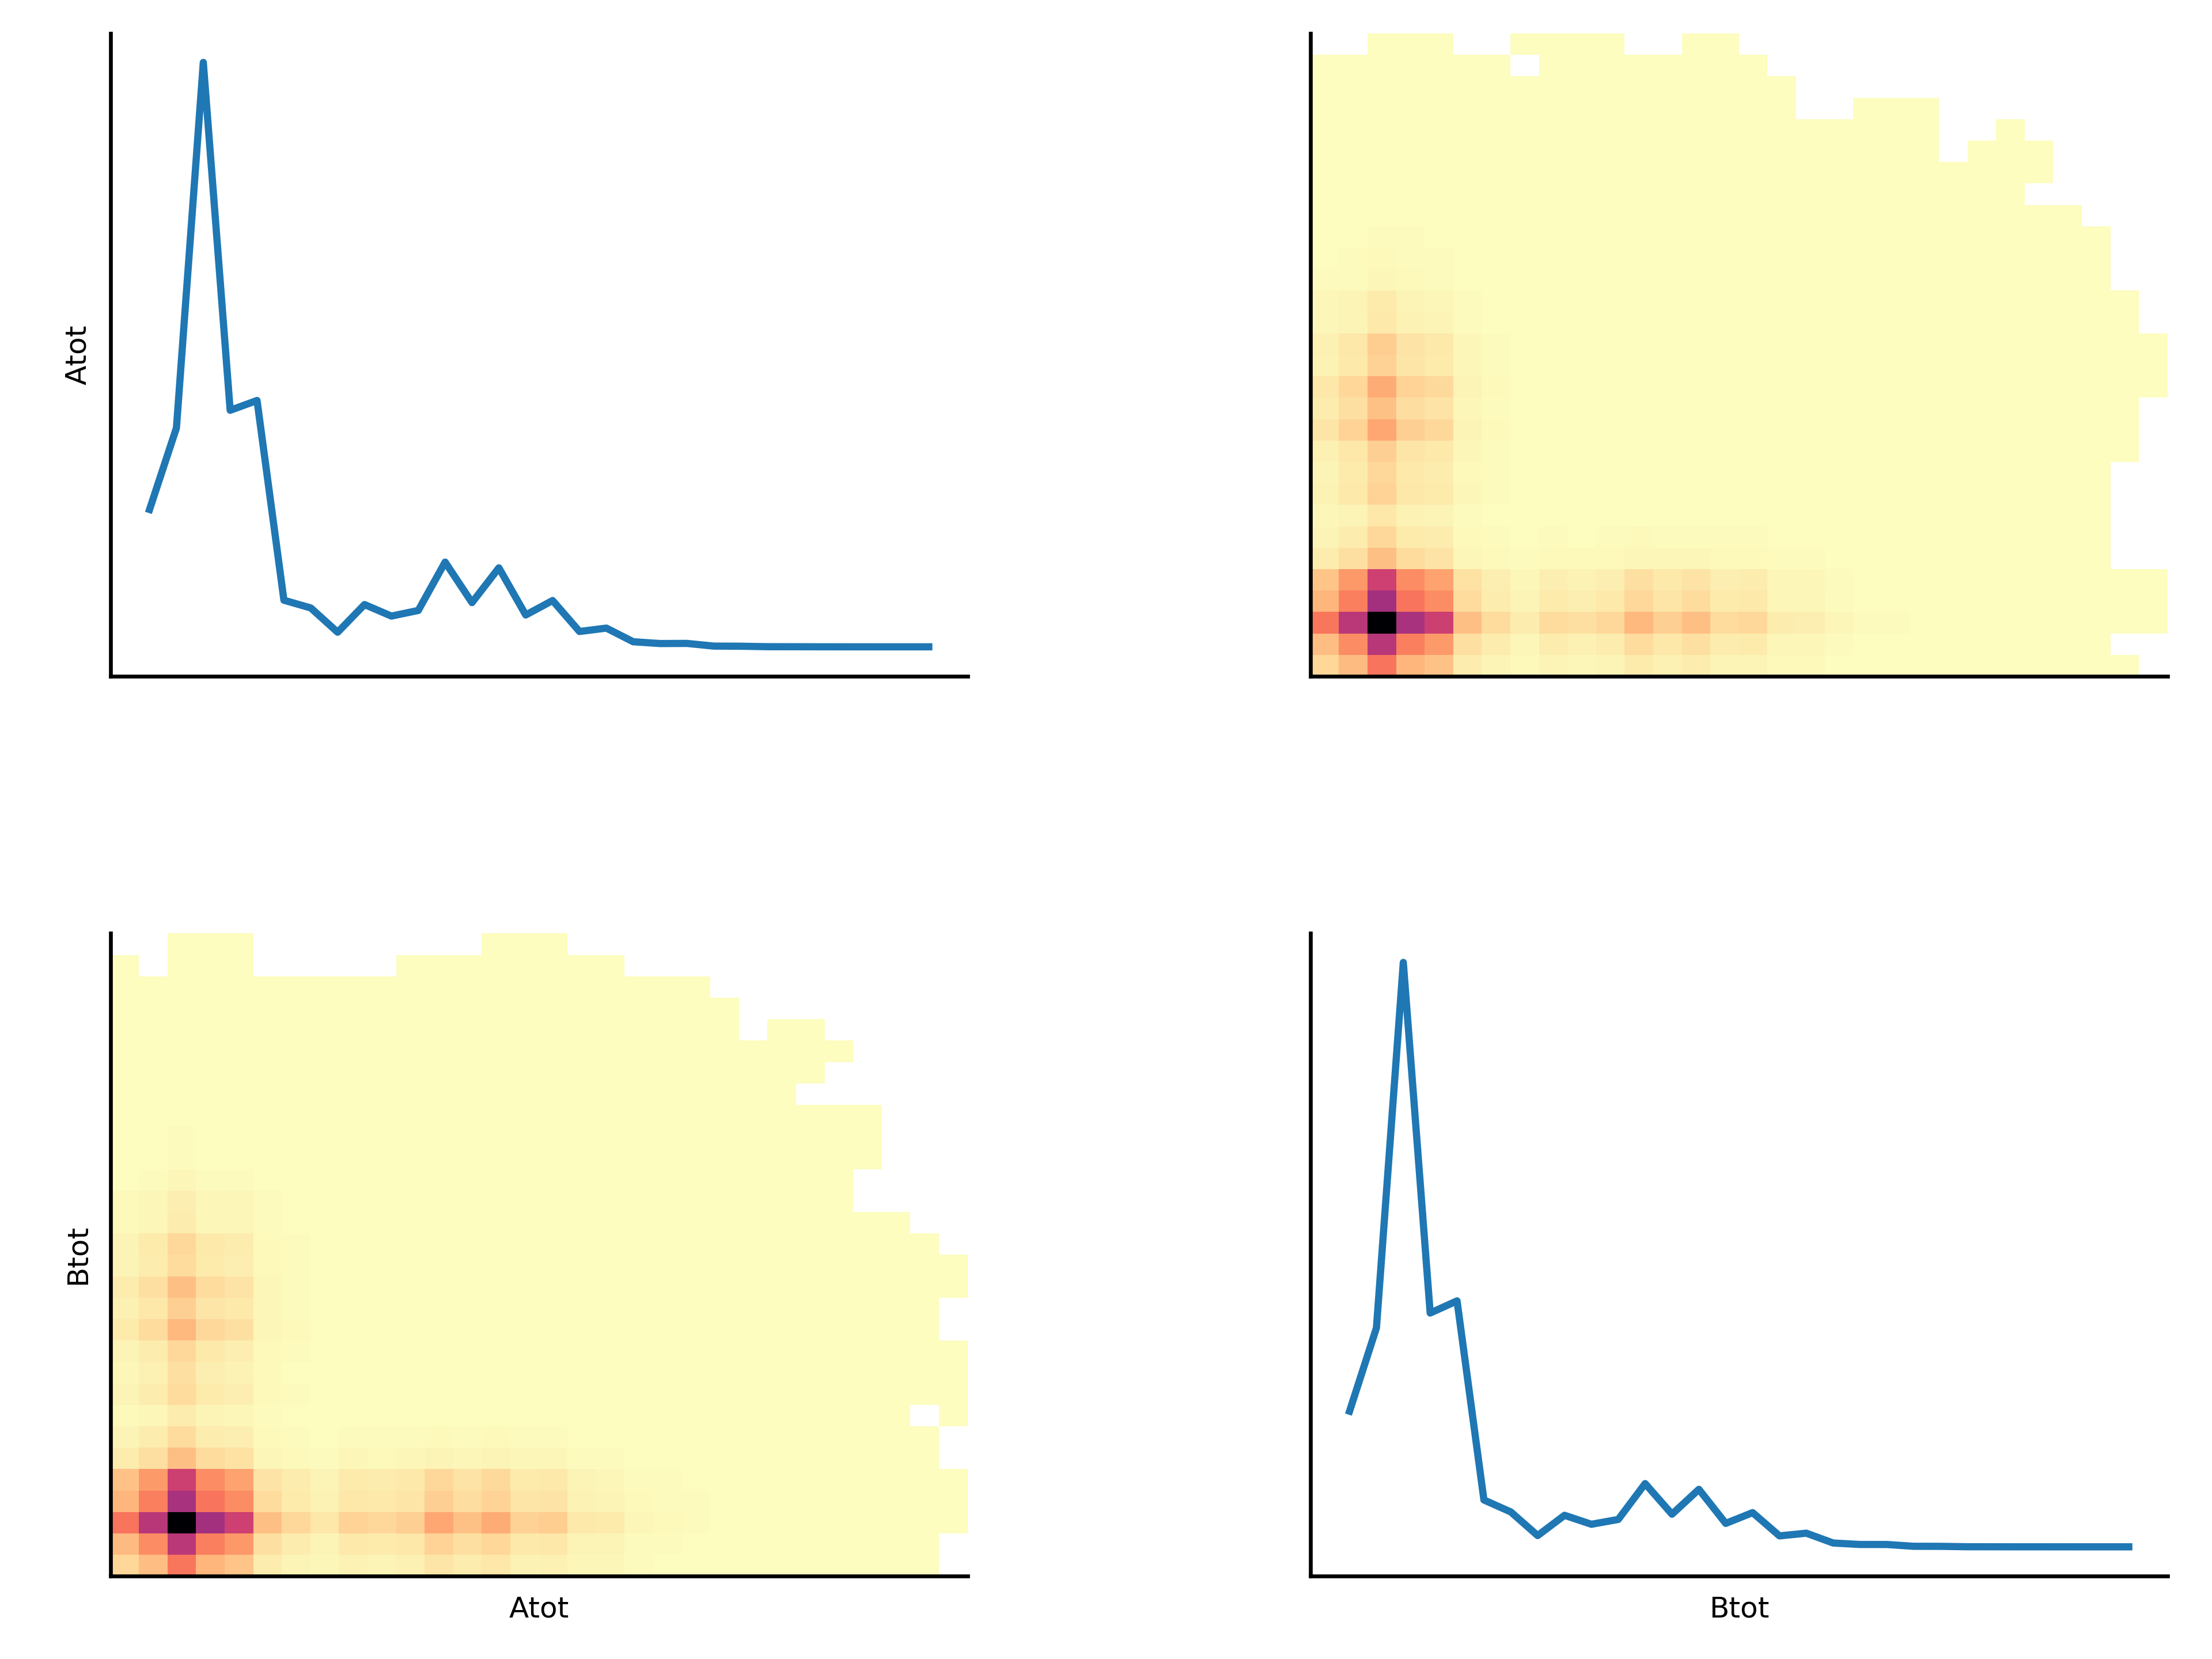

In [11]:
from IPython.display import Image
os.chdir("../WESTPA_BNG_analysis")
Image("pdists.png")

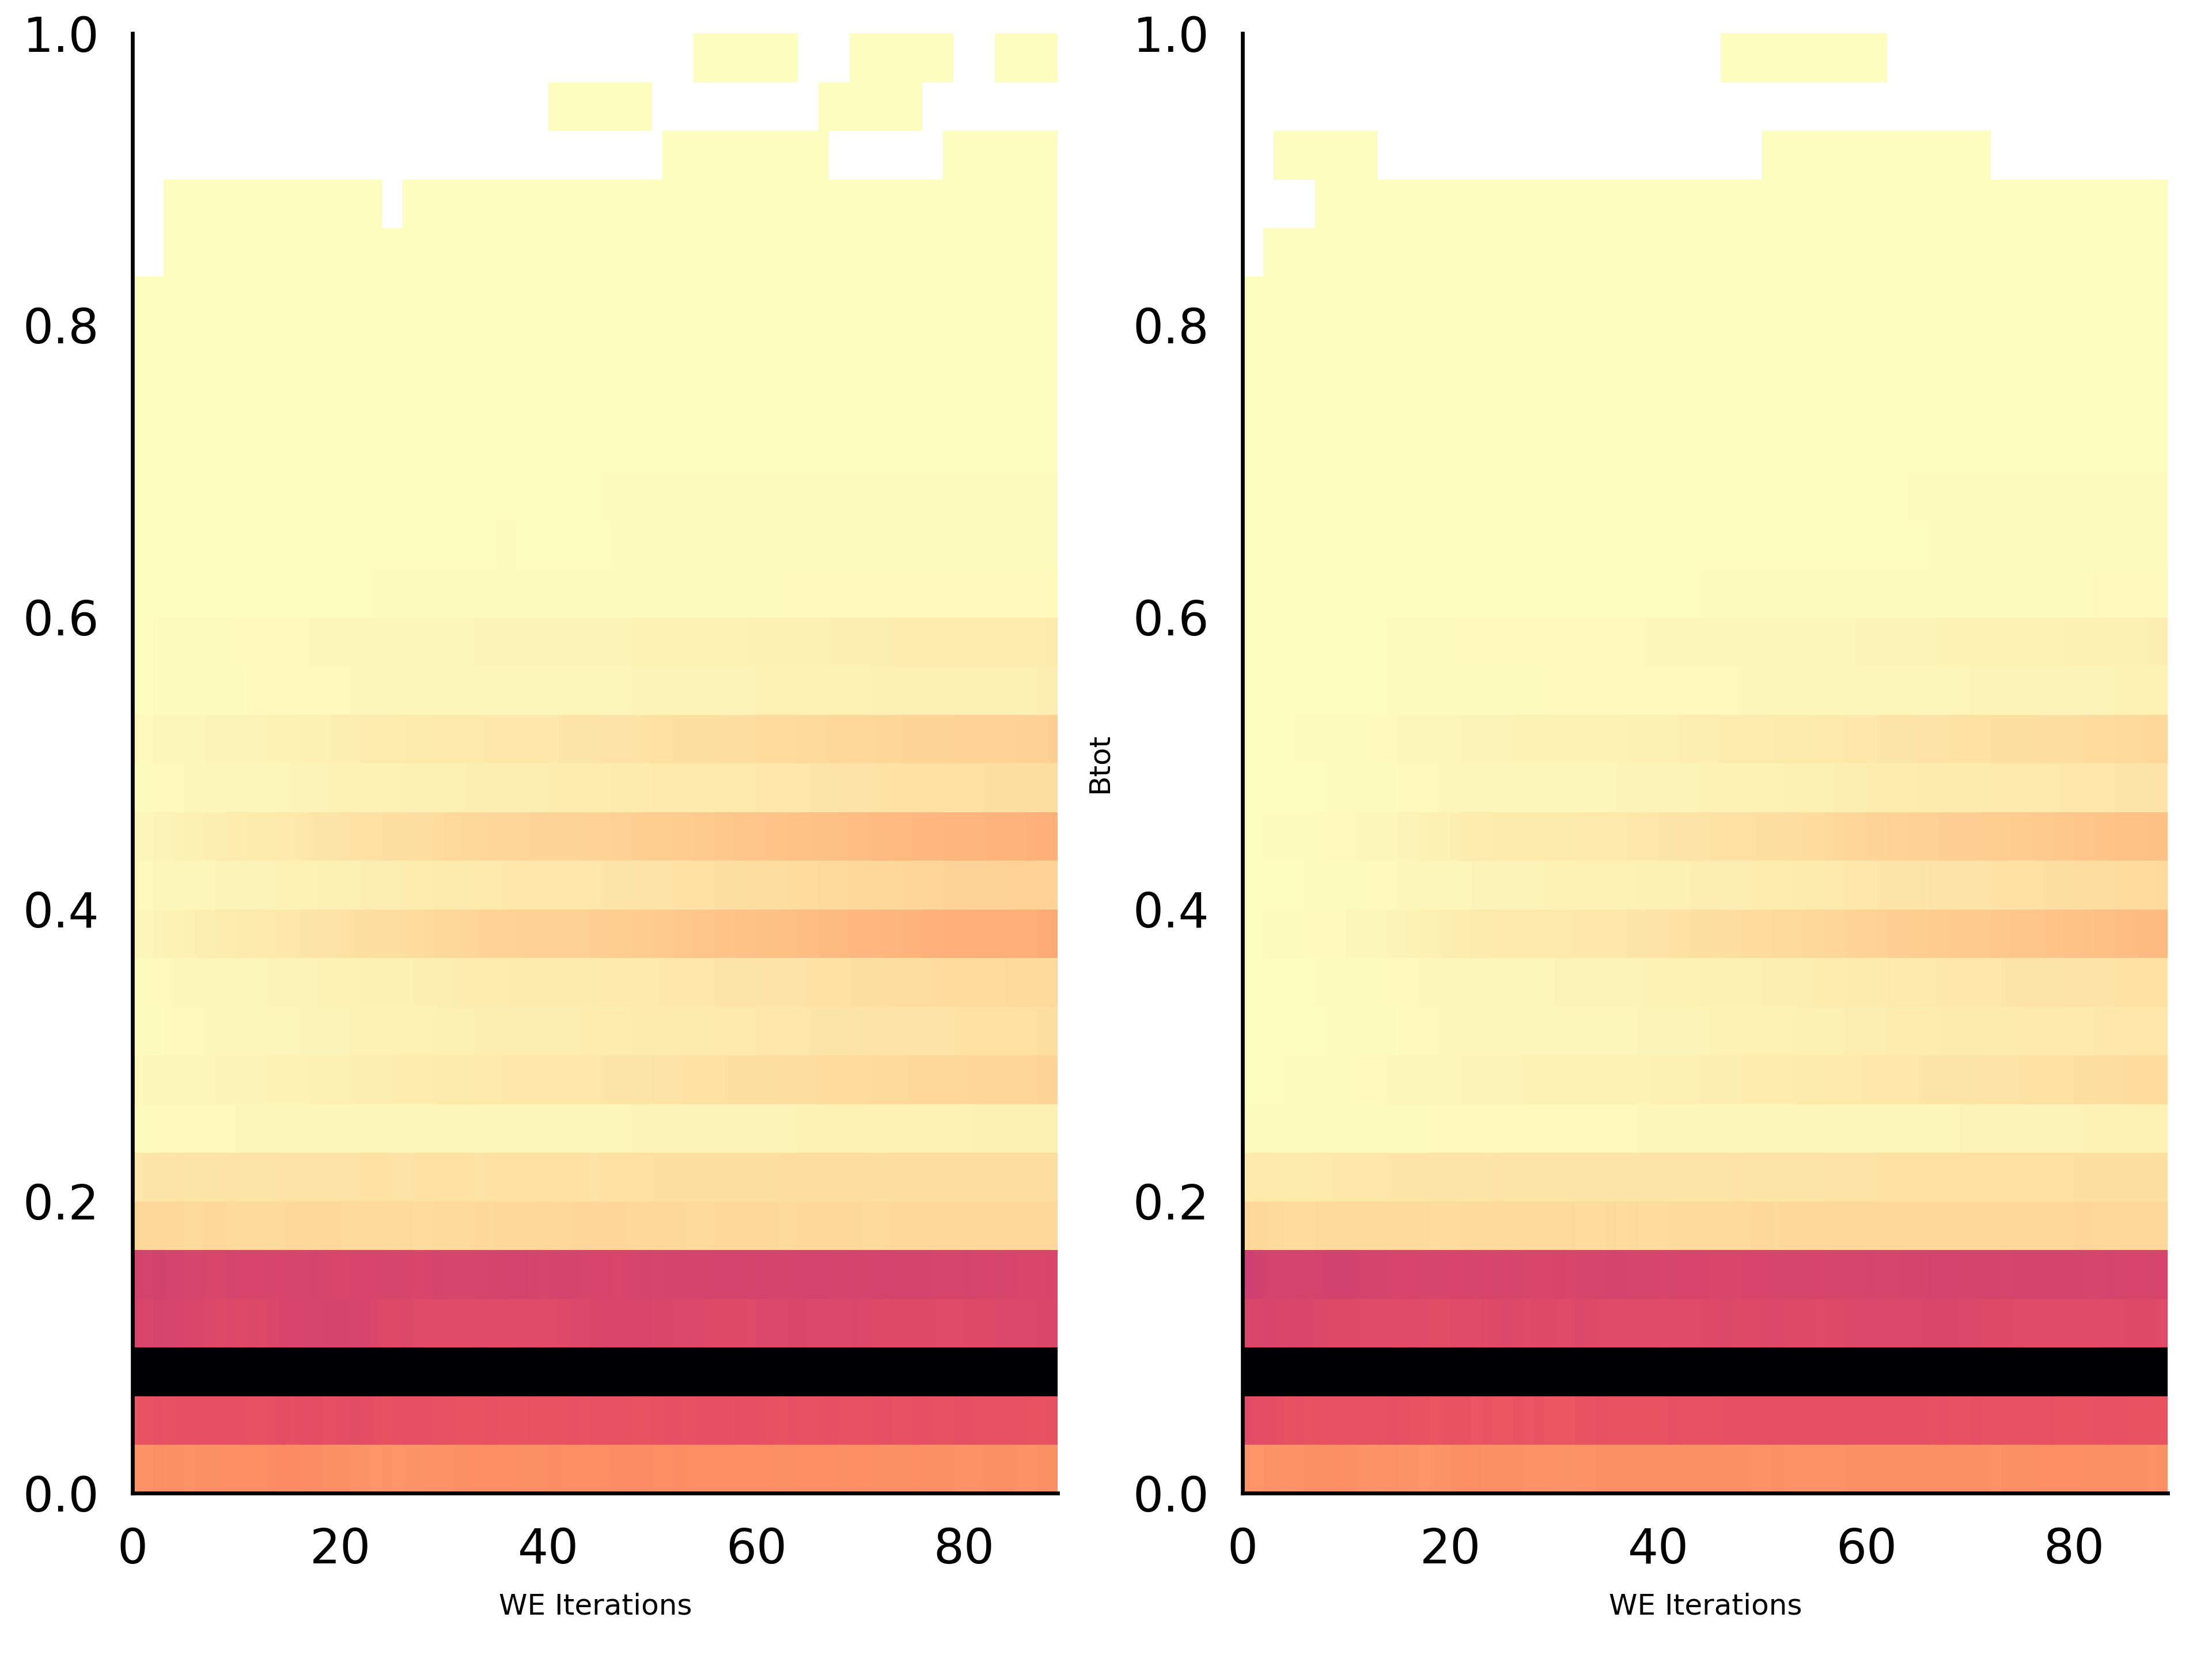

In [12]:
Image("evolution.png")